In [59]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from plotly.offline import plot, iplot
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
import plotly.express as px
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
import scipy.stats as stats
from plotly.subplots import make_subplots

import sklearn.linear_model as skl_lm
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn import tree
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import NearestNeighbors,KNeighborsClassifier
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,r2_score
from sklearn.naive_bayes import GaussianNB
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
import warnings
from sklearn.neighbors import KNeighborsRegressor

In [2]:
# read the data
df=pd.read_csv("archive/311-call-center-tracking-data-archived.csv")

In [26]:
# view the data 
#df

In [3]:
# convert "Date" column to datetime type
df1=df
df1["Date"]=pd.to_datetime(df1['Date'])

In [5]:
# create new dataframe name "df_count" which is original data group by date.
# df_count consist of 2 columns "Date"-date and "count"- number of calls for each date
df_count=df1[["Date"]].groupby(df1.Date).count()
df_count=df_count.rename(columns={"Date":'count'})
df_count=df_count.reset_index()

In [6]:
# split year, month and day from "Date" column
df_count['year'] = df_count['Date'].dt.year
df_count['month'] = df_count['Date'].dt.month
df_count['day'] = df_count['Date'].dt.day

In [7]:
# this function is created spetialy for this dataset with its columns name
def count(df,year,month):
    if month==0:
        out=df.loc[(df["year"]==year),:]
    else:
        out=df.loc[(df["year"]==year)&(df["month"]==month),:]
    return out

In [8]:
# month=0 means return result for all month for defined year
# I selected data fro 2014 year
df_count_2014=count(df_count,year=2014,month=0)

In [9]:
# here are functions that convert "Date" column do days, it means to number in [1,366] range
_DAYS_IN_MONTH = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

def _is_leap(year):
    return year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)

def _days_in_month(year, month):
    if month == 1 and _is_leap(year):
        return 29
    return _DAYS_IN_MONTH[month]

def days(year, month, day):
    return sum([_days_in_month(year, m) for m in range(0, month-1)]) + day

d = days(1992, 4, 14)
print(d)

105


In [10]:
# create new column name "days"
df_count_2014["days"]=df_count_2014.apply(lambda x: days(x['year'], x['month'],x["day"]), axis=1)

<ipython-input-10-855c486c086c>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [11]:
# plot new data: number of calls for each day iin 2014 year
trace_1 = go.Scatter(x = df_count_2014.days,y=df_count_2014["count"],mode = 'markers',name = "Frequency of call for each day)",
                     marker = dict(size = 10,color="rgba(152,0,0,0.5)")
                    )
layout  = dict(title = "Frequency of call for each day",
               xaxis = dict(title = "day",showgrid=False,showline=False,zeroline=False),
               yaxis = dict(title = "count",showgrid=False,showline=False,zeroline=False)
              )

data = [trace_1]
figure = dict(data=data,layout=layout)
iplot(figure)

Our goal is to predict the frequency of calls by using days.                                                            
At first, I used standard methods to predict frequency, then create a new approach which is a mixture of some methods, and finally find the most optimal solution with the highest accuracy from the used approaches. 

Let's start with the best approach.

## ARIMA model

In [13]:
# the data that will be used, where Date is index
data=pd.DataFrame({"count":list(df_count_2014["count"])},index=df_count_2014.Date)

In [27]:
data.head(2)

,count
Date,
2014-01-01,639
2014-01-02,2920


As we have time series we have to check the stationarity of data.

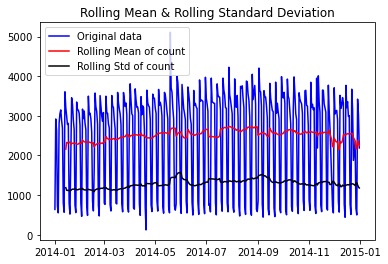

In [36]:
# check the stationarity by rolling mean and standart deviation
rolling_mean = data.rolling(window = 14).mean()
rolling_std = data.rolling(window = 14).std()
plt.plot(data, color = 'blue', label = 'Original data')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean of count')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std of count')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

I this case window size is 2 weeks by changing it you can get a very different result, I mean the lines show more variability.  
The rolling mean and standard deviation are not constant but also look stationary I guess that this series is stationary, let's check it more accurately by Dickey Fuller test.

In [432]:
# Dickey Fuller test.
result = adfuller(data['count'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -3.261364571098553
p-value: 0.016696318434084756
Critical Values:
	1%: -3.449226932880019
	5%: -2.869857365438656
	10%: -2.571201085130664


As the p-value is lower than 0.05 we can say that the time series is stationary with 95 % confidence.

Now we can use the ARIMA model to predict the number of calls.

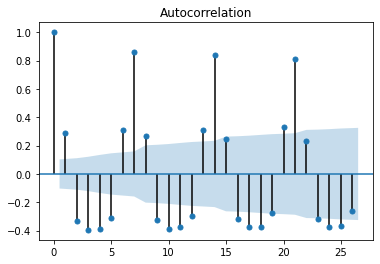

In [44]:
# Autocorrelation
plot_acf(data)
pyplot.show()
# from this plot, I get nothing I guess there is no MA lag or it is low

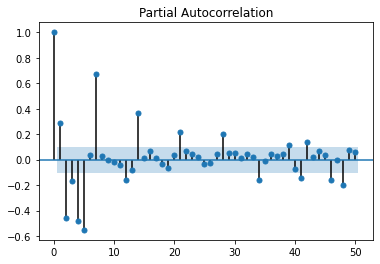

In [45]:
# partial autocorrelation
plot_pacf(data, lags=50)
pyplot.show()
# AR lag is high

In [15]:
# split data to train and test
train_data,test_data = train_test_split(data,test_size = 0.2,random_state=42,shuffle=False)

predicted=850.036504, expected=753.000000
predicted=737.089253, expected=533.000000
predicted=3028.949456, expected=3581.000000
predicted=3995.183845, expected=3419.000000
predicted=3436.230279, expected=3351.000000


/Users/mariam/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=3207.591406, expected=3305.000000
predicted=2810.817623, expected=3067.000000
predicted=819.481129, expected=866.000000
predicted=781.408932, expected=613.000000
predicted=3333.411274, expected=3631.000000
predicted=3555.680893, expected=3644.000000
predicted=3217.759827, expected=3263.000000
predicted=3362.636245, expected=3247.000000
predicted=2998.255908, expected=2763.000000
predicted=962.111610, expected=867.000000
predicted=884.601560, expected=616.000000
predicted=3422.030779, expected=3846.000000
predicted=3731.988556, expected=3210.000000
predicted=3182.198221, expected=3291.000000
predicted=3313.225038, expected=3155.000000
predicted=2731.589998, expected=3203.000000
predicted=885.416443, expected=726.000000
predicted=891.844619, expected=536.000000
predicted=3567.093875, expected=3948.000000
predicted=3422.356748, expected=2187.000000
predicted=3132.061548, expected=4008.000000
predicted=3339.528314, expected=3349.000000
predicted=2986.775676, expected=3095.000000


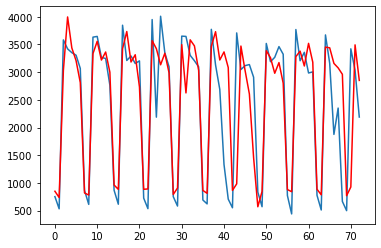

In [17]:
# fit the ARIMA(6,1,1) model on train data and use on test
predictions = list()
history = [x for x in train_data["count"]]
for t in range(len(test_data)):
    model = ARIMA(history, order=(6,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_data.iloc[t,:]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(list(test_data["count"]), predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(list(test_data["count"]))
pyplot.plot(predictions, color='red')
pyplot.show()

In [47]:
R2=r2_score(list(test_data["count"]), predictions)
n=len(predictions)
p=1
#adjusted
r2 = 1-(1-R2)*(n-1)/(n-p-1)
print("Adjusted R2 for ARIMA(6,1,1):",R2,"R2 for ARIMA(6,1,1):",r2)

Adjusted R2 for ARIMA(6,1,1): 0.6225269964686961 R2 for ARIMA(6,1,1): 0.617210475292199


predicted=982.963547, expected=753.000000
predicted=965.252173, expected=533.000000
predicted=2531.421457, expected=3581.000000
predicted=3675.437557, expected=3419.000000


/Users/mariam/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=3666.798650, expected=3351.000000
predicted=3367.243858, expected=3305.000000
predicted=2053.462142, expected=3067.000000
predicted=962.075725, expected=866.000000


/Users/mariam/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/Users/mariam/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=918.355904, expected=613.000000
predicted=2449.166932, expected=3631.000000


/Users/mariam/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=3579.187652, expected=3644.000000
predicted=3586.177668, expected=3263.000000


/Users/mariam/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available



predicted=3264.916194, expected=3247.000000
predicted=2070.939926, expected=2763.000000
predicted=1014.873552, expected=867.000000
predicted=1046.319386, expected=616.000000
predicted=2472.745615, expected=3846.000000
predicted=3585.872190, expected=3210.000000


/Users/mariam/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available



predicted=3538.479909, expected=3291.000000
predicted=3407.600279, expected=3155.000000


/Users/mariam/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=2112.669562, expected=3203.000000


/Users/mariam/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=1080.266958, expected=726.000000
predicted=928.588952, expected=536.000000
predicted=2537.910938, expected=3948.000000


/Users/mariam/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=3529.523952, expected=2187.000000
predicted=3653.308943, expected=4008.000000
predicted=3685.456828, expected=3349.000000


/Users/mariam/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=1952.724398, expected=3095.000000
predicted=1047.338179, expected=752.000000
predicted=917.690227, expected=583.000000
predicted=2489.485906, expected=3649.000000
predicted=3487.261484, expected=3644.000000
predicted=3565.395459, expected=3302.000000
predicted=3287.879000, expected=3205.000000
predicted=2126.202138, expected=3095.000000


/Users/mariam/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=1014.749162, expected=692.000000
predicted=978.024844, expected=622.000000
predicted=2485.797189, expected=3772.000000
predicted=3474.649650, expected=3129.000000
predicted=3592.027459, expected=2688.000000
predicted=3547.444697, expected=1333.000000
predicted=2674.637476, expected=708.000000


/Users/mariam/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available



predicted=2122.587282, expected=552.000000


/Users/mariam/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available



predicted=2156.273874, expected=3707.000000


/Users/mariam/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available



predicted=2808.095816, expected=3046.000000
predicted=3149.691244, expected=3117.000000
predicted=3876.487099, expected=3136.000000


/Users/mariam/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available



predicted=3137.086374, expected=2908.000000


/Users/mariam/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/Users/mariam/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=2122.748885, expected=835.000000


/Users/mariam/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=1281.277931, expected=571.000000
predicted=1889.156495, expected=3517.000000
predicted=2676.440405, expected=3187.000000
predicted=3164.201528, expected=3267.000000
predicted=3757.381021, expected=3460.000000
predicted=2997.868092, expected=3322.000000
predicted=1763.671599, expected=772.000000


/Users/mariam/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning:

overflow encountered in exp

/Users/mariam/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning:

invalid value encountered in true_divide

/Users/mariam/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning:

overflow encountered in exp

/Users/mariam/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning:

invalid value encountered in true_divide



predicted=983.163039, expected=441.000000
predicted=1800.723865, expected=3768.000000
predicted=2754.728051, expected=3205.000000
predicted=3100.477964, expected=3357.000000
predicted=3659.453272, expected=2984.000000
predicted=2788.431485, expected=3004.000000
predicted=1821.003515, expected=777.000000
predicted=1094.263260, expected=512.000000
predicted=2031.510400, expected=3671.000000
predicted=2996.553562, expected=3159.000000
predicted=3304.095197, expected=1876.000000
predicted=3745.529377, expected=2351.000000
predicted=3071.309141, expected=666.000000
predicted=2436.397836, expected=500.000000
predicted=2960.513976, expected=3420.000000
predicted=3242.287021, expected=3035.000000
predicted=2759.335231, expected=2189.000000
Test MSE: 862080.721


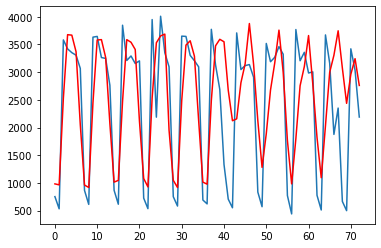

In [499]:
# another case
predictions = list()
history = [x for x in train_data["count"]]
for t in range(len(test_data)):
    model = ARIMA(history, order=(2,0,4))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_data.iloc[t,:]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(list(test_data["count"]), predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(list(test_data["count"]))
pyplot.plot(predictions, color='red')
pyplot.show()

In [ ]:
# for ARIMA(2,0,4) adj. R2= 0.4311695826683586 , R2 =0.439070005131298

In [516]:
# find the best parameters for ARIMA model 

def evaluate_arima_model(X, arima_order):
# prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
# make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])

    error = mean_squared_error(test, predictions)
    return error
 

def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
# load dataset
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(data.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=1620671.157
ARIMA(0, 0, 1) MSE=1359543.495
ARIMA(0, 0, 2) MSE=1193545.248
ARIMA(0, 1, 0) MSE=2360420.976
ARIMA(0, 1, 1) MSE=1669836.249
ARIMA(0, 1, 2) MSE=1386385.081
ARIMA(0, 2, 0) MSE=5083075.263
ARIMA(0, 2, 1) MSE=2383144.659
ARIMA(0, 2, 2) MSE=1662962.674
ARIMA(1, 0, 0) MSE=1506735.859
ARIMA(1, 0, 1) MSE=1350872.773
ARIMA(1, 0, 2) MSE=1112443.410
ARIMA(1, 1, 0) MSE=2349030.738
ARIMA(1, 2, 0) MSE=4451332.191
ARIMA(2, 0, 0) MSE=1211138.548
ARIMA(2, 0, 1) MSE=990145.712
ARIMA(2, 0, 2) MSE=840572.130
ARIMA(2, 1, 0) MSE=2003736.793
ARIMA(2, 1, 2) MSE=1044178.764
ARIMA(2, 2, 0) MSE=3436166.203
ARIMA(4, 0, 0) MSE=930244.103
ARIMA(4, 0, 1) MSE=807258.900
ARIMA(4, 1, 0) MSE=1813236.661
ARIMA(4, 1, 2) MSE=887726.010
ARIMA(4, 2, 0) MSE=3201535.485
ARIMA(6, 0, 0) MSE=668345.006
ARIMA(6, 0, 1) MSE=622816.378
ARIMA(6, 1, 0) MSE=494282.681
ARIMA(6, 1, 1) MSE=493881.316
ARIMA(6, 1, 2) MSE=498393.190
Best ARIMA(6, 1, 1) MSE=493881.316


## Regression

The second approach is regression, I used regression methods that probably could work.

In [51]:
# simple linear regression
regr1 = skl_lm.LinearRegression()
X = df_count_2014.day.values.reshape(-1,1)
y = df_count_2014["count"]
regr1.fit(X,y)
print("Score for linear regression:", regr1.score(X,y))
# this is a very bad result 

Score for linear regression: 9.689917177369001e-05


In [52]:
# let's use combination of polynomial and linear regression
regr = skl_lm.LinearRegression()
for i in range(1,10):
    Input=[('polynomial',PolynomialFeatures(degree=i)),('model',regr)]
    pipe=Pipeline(Input)
    pipe.fit(X,y)
    print("R^2 value for Polynomial regression with degree=",str(i),": ",pipe.score(X,y))
# results are still bad 

R^2 value for Polynomial regression with degree= 1 :  9.689917177369001e-05
R^2 value for Polynomial regression with degree= 2 :  0.0010007373082366877
R^2 value for Polynomial regression with degree= 3 :  0.0012169333822807937
R^2 value for Polynomial regression with degree= 4 :  0.0014194823928925793
R^2 value for Polynomial regression with degree= 5 :  0.0014811113597590353
R^2 value for Polynomial regression with degree= 6 :  0.003433216084862356
R^2 value for Polynomial regression with degree= 7 :  0.0034332835620008995
R^2 value for Polynomial regression with degree= 8 :  0.008465510143019217
R^2 value for Polynomial regression with degree= 9 :  0.008549302249690305


In [53]:
# r2 is higher for degree=9
Input=[('polynomial',PolynomialFeatures(degree=9)),('model',regr)]
pipe=Pipeline(Input)
pipe.fit(X,y)

Pipeline(steps=[('polynomial', PolynomialFeatures(degree=9)),
                ('model', LinearRegression())])

In [55]:
# the next method is support vector regressor
mod_linearsvc = svm.SVR(kernel="linear",max_iter=10000)
mod_rbfsvc = svm.SVR(kernel="rbf",max_iter=10000)
mod_linearsvc.fit(X,y);
mod_rbfsvc.fit(X,y);

In [56]:
print("LinearSVC - > ",mod_linearsvc.score(X,y))

LinearSVC - >  -0.22260074688706188


In [57]:
print("RBFSVC - > ",mod_rbfsvc.score(X,y))

RBFSVC - >  -0.2266400154085455


In [58]:
# results are close and awful, negative score means that method is worst

In [62]:
# the next one is Decision Tree
mod_reg  = tree.DecisionTreeRegressor(max_depth = 13)
mod_reg_fit = mod_reg.fit(X,y)
print("Score for Decision Tree: ",mod_reg_fit.score(X,y))
# parameter was taken from results below

Score for Decision Tree:  0.024287598725552084


In [61]:
for j in np.arange(20)+2:
    mod_reg = tree.DecisionTreeRegressor(max_depth = j)
    mod_reg_fit = mod_reg.fit(X,y)
    print("max_depth = ", j, "Score = ", mod_reg_fit.score(X,y))

max_depth =  2 Score =  0.005061176053588801
max_depth =  3 Score =  0.006155754903449773
max_depth =  4 Score =  0.009315721910560182
max_depth =  5 Score =  0.010178614570040323
max_depth =  6 Score =  0.013925744665961415
max_depth =  7 Score =  0.016199987305787644
max_depth =  8 Score =  0.01694763593504023
max_depth =  9 Score =  0.017204892015232898
max_depth =  10 Score =  0.019170638491531666
max_depth =  11 Score =  0.021919522166846894
max_depth =  12 Score =  0.02304183752544975
max_depth =  13 Score =  0.024287598725552084
max_depth =  14 Score =  0.024287598725552084
max_depth =  15 Score =  0.024287598725552084
max_depth =  16 Score =  0.024287598725552084
max_depth =  17 Score =  0.024287598725552084
max_depth =  18 Score =  0.024287598725552084
max_depth =  19 Score =  0.024287598725552084
max_depth =  20 Score =  0.024287598725552084
max_depth =  21 Score =  0.024287598725552084


In [63]:
# results are still bad

In [64]:
# The next one is AdaBoost Regressor
mod = ensemble.AdaBoostRegressor(tree.DecisionTreeRegressor(max_depth =1),
                                 n_estimators = 200,
                                )
mod.fit(X,y);

In [65]:
print("AdaBoostRegressor - > ",mod.score(X,y))
# model is worst

AdaBoostRegressor - >  -0.02458870818271941


In [71]:
# the next one is the nearest neighbor
neigh = KNeighborsRegressor(n_neighbors=12)
neigh.fit(X,y)

KNeighborsRegressor(n_neighbors=12)

In [70]:
score = np.array([])
for j in np.arange(20) +1:
    mod_reg = KNeighborsRegressor(n_neighbors = j)
    mod_reg.fit(X,y)
    score = np.append(score, mod_reg.score(X,y))
    print("j->", j, "score->",mod_reg.score(X,y))
param = np.argmax(score) + 1
param

j-> 1 score-> -1.0136357647518888
j-> 2 score-> -0.3403044893792406
j-> 3 score-> -0.18059614185737005
j-> 4 score-> -0.12560479098684563
j-> 5 score-> -0.095798519350633
j-> 6 score-> -0.06803167641569963
j-> 7 score-> -0.036562641018480946
j-> 8 score-> -0.035718644806508326
j-> 9 score-> -0.013674594619058178
j-> 10 score-> -0.0032312404386742877
j-> 11 score-> 0.013885917488186905
j-> 12 score-> 0.022449088717694354
j-> 13 score-> 0.01676559850069026
j-> 14 score-> 0.012270392098687077
j-> 15 score-> 0.010399973491102887
j-> 16 score-> 0.005392383176365145
j-> 17 score-> 0.012274207952776228
j-> 18 score-> 0.013018564740433836
j-> 19 score-> 0.008242135636774117
j-> 20 score-> 0.008329371293955945


12

In [73]:
print("Score for nearest neighbor regressor: ",neigh.score(X,y))

Score for nearest neighbor regressor:  0.022449088717694354


The highest score is approximately 2% it is very bad.

In [75]:
# plot of all results
trace_1 = go.Scatter(x = df_count_2014.days,y=df_count_2014["count"],mode = 'markers',name = "original",
                     marker = dict(size = 10,color="rgba(152,0,0,0.5)")
                    )
trace_2 = go.Scatter(x = df_count_2014.days,y=regr1.predict(X),mode = 'lines',name = "Linear reg",
                     marker = dict(size = 10,color="rgba(152,100,0,0.5)")
                    )
trace_3 = go.Scatter(x = df_count_2014.days,y=pipe.predict(X),mode = 'lines',name = "Polinomial",
                     marker = dict(size = 10,color="rgba(152,0,1000,0.5)")
                    )
trace_4 = go.Scatter(x = df_count_2014.days,y=mod_linearsvc.predict(X),mode = 'lines',name = "SVM",
                     marker = dict(size = 10,color="rgba(2,100,100,0.5)")
                     
                    )
trace_5 = go.Scatter(x = df_count_2014.days,y=mod_reg_fit.predict(X),mode = 'lines',name = "Tree",
                     marker = dict(size = 10,color="rgba(2,0,1000,0.5)")
                     
                    )
trace_6 = go.Scatter(x = df_count_2014.days,y=neigh.predict(X),mode = 'lines',name = "KNN",
                     marker = dict(size = 10,color="rgba(2,0,10,0.5)")
                     
                    )
trace_7 = go.Scatter(x = df_count_2014.days,y=np.zeros(len(df_count_2014["count"]))+df_count_2014["count"].mean(),mode = 'lines',name = "Average number of calls",
                     marker = dict(size = 10,color="rgba(20,20,200,0.5)")
                     
                    )

layout  = dict(title = "Frequency of call for each day",
               xaxis = dict(title = "day",showgrid=False,showline=False,zeroline=False),
               yaxis = dict(title = "count",showgrid=False,showline=False,zeroline=False)
              )

data = [trace_1,trace_2,trace_3,trace_4,trace_5,trace_6,trace_7]
figure = dict(data=data,layout=layout)
iplot(figure)

I also apply all these approaches to transformed data where new data is the difference but the results are still bad that why I remove these experiments.

## The last approach

From the plot upper you can see that frequency can be divided into two groups, the average frequency of the first group is around 900, for the second: 3000. That is why I divided the prediction process into three parts:           
1)by using clustering algorithms predict two clusters                                              
2)now we have labeled data, find the best classification algorithm to predict the test data by using train data. It means that first we should predict the label for test date then also predict frequency.     
3)now is time to get the best regression model to predict frequency by using not only day but also label.

### Clustering on all data

In [76]:
# by using DBSCAN clustering algorithm split the data to two parts
std=np.std(df_count_2014["count"])
X_dbscan=df_count_2014[["count","days"]]
clustering_dbscan = DBSCAN(eps=std*0.3, min_samples=2).fit(X_dbscan)
label=clustering_dbscan.labels_
X_dbscan["label"]=label

<ipython-input-76-1f111bf7e14b>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [111]:
fig = px.scatter(x = X_dbscan.days, y = X_dbscan["count"], color=X_dbscan.label.astype(str),
                 title="Result of DBSCAN clustering")

fig.show()

### Train-test split

In [77]:
# split new data with an additional label to test and train data
train,test = train_test_split(X_dbscan,test_size = 0.2,random_state=42)

### Classification on train

Now we should find the best classification algorithm.

In [129]:
# The first one is AdaBoost Classifier
mod1 = ensemble.AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth =21),
                                 n_estimators = 200,
                                )
mod1.fit(train.days.values.reshape(-1,1),train.label);
# mod1_pred=mod1.predict(mod1.predict(test.days.values.reshape(1, -1)))
print("Score of AdaBoostClassifier: ",mod1.score(test.days.values.reshape(-1,1),test.label))


######## SVC

mod_linearsvc = svm.SVC(kernel="rbf",max_iter=10000)
mod_linearsvc.fit(train.days.values.reshape(-1,1),train.label);
# mod_linearsvc_pred= mod_linearsvc.predict(mod1.predict(test.days.values.reshape(-1,1)))
print("Score of SVC: ",mod_linearsvc.score(test.days.values.reshape(-1,1),test.label))

######## GaussianNB
naive_bayes = GaussianNB()
mod_naive_bayes = naive_bayes.fit(train.days.values.reshape(-1,1),train.label)
# predict for validation data set
naive_bayes_pred = mod_naive_bayes.predict(test.days.values.reshape(-1,1))
print("Score of Naive Bayes Classifier: ", accuracy_score(test.label,naive_bayes_pred))

######## KNN
knn=KNeighborsClassifier(2)
mod_knn=knn.fit(train.days.values.reshape(-1,1),train.label)
knn_pred = mod_knn.predict(test.days.values.reshape(-1,1))
print("Score of KNN: ", accuracy_score(test.label,knn_pred))

####### LogisticRegression
log_reg = skl_lm.LogisticRegression(max_iter=1000,tol=0.000001)
mod_log_reg = log_reg.fit(train.days.values.reshape(-1,1),train.label)
mod_log_reg_pred=mod_log_reg.predict(test.days.values.reshape(-1,1))
print( "Score of LogisticRegression",accuracy_score(test.label,mod_log_reg_pred))

Score of AdaBoostClassifier:  0.684931506849315
Score of SVC:  0.7397260273972602
Score of Naive Bayes Classifier:  0.7397260273972602
Score of KNN:  0.589041095890411
Score of LogisticRegression 0.7397260273972602


In [112]:
for j in np.arange(20)+2:
    mod_reg1 = tree.DecisionTreeClassifier(max_depth = j)
    mod_reg_fit1 = mod_reg1.fit(X_dbscan.days.values.reshape(-1,1),X_dbscan.label)
    print("max_depth = ", j, "Score = ", mod_reg_fit1.score(X_dbscan.days.values.reshape(-1,1),X_dbscan.label))

max_depth =  2 Score =  0.699724517906336
max_depth =  3 Score =  0.7052341597796143
max_depth =  4 Score =  0.7052341597796143
max_depth =  5 Score =  0.7107438016528925
max_depth =  6 Score =  0.7107438016528925
max_depth =  7 Score =  0.7162534435261708
max_depth =  8 Score =  0.7162534435261708
max_depth =  9 Score =  0.721763085399449
max_depth =  10 Score =  0.721763085399449
max_depth =  11 Score =  0.7272727272727273
max_depth =  12 Score =  0.7300275482093664
max_depth =  13 Score =  0.7355371900826446
max_depth =  14 Score =  0.7355371900826446
max_depth =  15 Score =  0.7410468319559229
max_depth =  16 Score =  0.7410468319559229
max_depth =  17 Score =  0.7465564738292011
max_depth =  18 Score =  0.7465564738292011
max_depth =  19 Score =  0.7520661157024794
max_depth =  20 Score =  0.7520661157024794
max_depth =  21 Score =  0.7575757575757576


In [126]:
for j in np.arange(20)+2:
    knn=KNeighborsClassifier(j)
    mod_knn=knn.fit(train.days.values.reshape(-1,1),train.label)
    knn_pred = mod_knn.predict(test.days.values.reshape(-1,1))
    mod_reg1 = tree.DecisionTreeClassifier(max_depth = j)
    mod_reg_fit1 = mod_reg1.fit(X_dbscan.days.values.reshape(-1,1),X_dbscan.label)
    print("max_depth = ", j, "Score = ", mod_reg_fit1.score(X_dbscan.days.values.reshape(-1,1),X_dbscan.label))

max_depth =  2 Score =  0.699724517906336
max_depth =  3 Score =  0.7052341597796143
max_depth =  4 Score =  0.7052341597796143
max_depth =  5 Score =  0.7107438016528925
max_depth =  6 Score =  0.7107438016528925
max_depth =  7 Score =  0.7162534435261708
max_depth =  8 Score =  0.7162534435261708
max_depth =  9 Score =  0.721763085399449
max_depth =  10 Score =  0.721763085399449
max_depth =  11 Score =  0.7272727272727273
max_depth =  12 Score =  0.7300275482093664
max_depth =  13 Score =  0.7355371900826446
max_depth =  14 Score =  0.7355371900826446
max_depth =  15 Score =  0.7410468319559229
max_depth =  16 Score =  0.7410468319559229
max_depth =  17 Score =  0.7465564738292011
max_depth =  18 Score =  0.7465564738292011
max_depth =  19 Score =  0.7520661157024794
max_depth =  20 Score =  0.7520661157024794
max_depth =  21 Score =  0.7575757575757576


In [130]:
# plot of knn classification
fig=px.scatter(x = test.days, y = test["count"], color=mod_knn.predict(test.days.values.reshape(-1,1)).astype(str),
                 title="Test data")
                    
    

fig.show()

In [96]:
# expected view
fig = px.scatter(x = test.days, y = test["count"], color=test.label.astype(str),
                 title="Test data")


fig.show()

### Regression 

In [107]:
regr_new = skl_lm.LinearRegression()
X = train.loc[:,["days","label"]]
y = train["count"]
regr_new.fit(X,y)
test["pred_label"]=mod1.predict(test.days.values.reshape(-1,1))

print("Score of linear regression for test(clustered data): ",regr_new.score(test.loc[:,["days","label"]],test["count"]))

print("Score of linear regression for test(classified data): ",regr_new.score(test.loc[:,["days","pred_label"]],test["count"]))
### here you can see that problem is in the classification process because the approach works only in case of accurate prediction of class

Score of linear regression for test(clustered data):  0.9318990219794896
Score of linear regression for test(classified data):  -0.5272817761397026


<ipython-input-107-2d96f5cc578a>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [131]:
##### Decision Tree
mod_reg = tree.DecisionTreeRegressor(max_depth = 6)
mod_reg_fit = mod_reg.fit(X,y)
print("Scor of Decision Tree(classified data): ", mod_reg_fit.score(test[["days","pred_label"]],test["count"]))
print("Scor of Decision Tree(clustered data): ", mod_reg_fit.score(test[["days","label"]],test["count"]))
#### the same is here

Scor of Decision Tree(classified data):  -0.6409834289941674
Scor of Decision Tree(clustered data):  0.9375453397650134


In a conclusion, I think the last approach should work if I can found a good classification algorithm.
But from all methods, ARIMA(6,1,1) is the best.